# Goals of the Notebook

Our filter is supposed to detect Out-Of-Domain (OOD) sentences from In-Domain (ID) sentences in a conversation between a support agent and a customer.

Here the domain (ID) is the full FAQ scrapped from the Europcar website (from https://faq.europcar.com/ and subpages). The domain is "Car rental".

The baseline is an anomaly detection algorithm that was trained on ONLY on the domain (ID) sentences as follows:
 - split the FAQ into sentences and for each sentence compute an embeddings vector from a pre-trained transformer: this vector captures the semantic of the sentence.
 - Any transformer model that says having "euclidian distance" as one of its relevant similarity is fine. Euclidian distance is important as we will use spatial proximity
 - Now that each sentence of the FAQ is a point in space (coordinates are the semantic features of the embeddings) fit a Gaussian distribution to it.

For every new sentence at test time:
  - embed it using the same transformer model: we now have a new point in the "embeddings" n-dimensional space
  - is this new point is "too-far" from the center it is considered OOD. The distance is a variation of the euclidian distance that takes into account the covariance of each embedding variable. In picture below every ellipse is at same distance from the center.

![alternative text](Anomaly-detection-using-multivariate-Gaussian-distribution.png)

The important thing on the test set (which should more be a cross-validation set) is to choose the right cut-off distance.

The goals in this notebook are:
- find the most relevant performance metric: useful to compare multiple models and parameter changes
- assess a first iteration of the filter model performance, to get a baseline model
- try to find the correct cutoff distance by eyeballing the result. But then try to automate the selection of the cutoff distance: this is useful as we plan to run a lot of model iterations and do model selection automatically.
- Find a user-friendly way to get a confidence score and that achieves a good tradeoff between precision and recall.
- Identify first directions of enhancements, in particular how datasets can be further improved

In [8]:
from pathlib import Path
from pipelines.persistence import load_pipeline
from dataload.dataloading import DataFilesRegistry
from pipelines.impl.anomaly_detection import GaussianEmbeddingsAnomalyDetector

CAPSTONE_FOLDER = Path("/Users/jlinho/Desktop/capstone/")
DATAFILES_FOLDER = CAPSTONE_FOLDER / "datasources"
MODELS_FOLDER = CAPSTONE_FOLDER / "models"

data_registry = DataFilesRegistry(DATAFILES_FOLDER)


detector = load_pipeline(MODELS_FOLDER / "20220127_16-50-10", GaussianEmbeddingsAnomalyDetector)


print(f"Name: {detector.name}")
print("Train params used: ")
print(detector.run_params)
print("Files used for training:")
print(detector.files)

Name: GaussianEmbeddingsAnomalyDetector
Train params used: 
{'embedder_name': 'all-MiniLM-L6-v2', 'robust_covariance': True}
Files used for training:
FilterTrainFiles(train_id=['europcar'], train_ood=[], validation_id='validation_id', validation_ood='validation_ood')


## Training a simple model

## Define validation set and run model on it

This small set of data has been generated by asking chatGPT to invent a dialog between a support agent and a customer of a car rental company.

In [9]:
from pipelines.impl.anomaly_detection import _file_sentences

test_id_sentences = list(_file_sentences("validation_id", data_registry))
test_ood_sentences = list(_file_sentences("validation_ood", data_registry))


In [10]:
test_id_sentences

['i will send the truck to your location and arrange for a replacement vehicle to be delivered to you as soon as possible.',
 'how can i pay the rental?',
 'what is the minimum age to rent a car?',
 'so, for one additional day, the charge would be $50.',
 'where should i deposit the keys of my car?',
 'what is the maximum number of passengers?',
 'unfortunately, there will be additional charges for extending the rental period.',
 'i want to rent a car.',
 'what is the maximum number of drivers?',
 'should i return the car with a full tank?',
 'hello, thank you for reaching out to our car rental company.',
 'in that case, i would recommend that you safely pull over and wait for a tow truck to take the vehicle to the nearest service center.',
 'and i need to return it one day later than planned.',
 'the oil level is fine, but the check engine light is on.',
 'the daily rate for the car you rented will apply for each additional day.',
 'how to extend the rental period?',
 'at what time ca

In [4]:
test_ood_sentences

["what's up?",
 'can you tell me how much that will be?',
 'can you please check the oil level and let me know if it is low?',
 'i am doing great',
 'hi, how is it going?',
 "the engine is making a strange noise and it feels like it's struggling to accelerate.",
 'i can check the fly rates for you.',
 'my name is john',
 'did you take medicine?',
 'i hear things once in a while.',
 'a man is riding a horse.',
 'a monkey is playing drums.',
 'hi, nice to meet you.',
 'i apologize for the issue.',
 'thank you for your help.',
 "you're welcome.",
 "i'm sorry to hear that.",
 'i understand.',
 'get well soon dear',
 'tell me a joke',
 "please let me know if there's anything else i can assist you with.",
 'what about yesterday?',
 'i am fine',
 'thank you for that information.',
 'ok, that sounds good.',
 'i apologize for the inconvenience.']

In [11]:
import seaborn as sns
import numpy as np

# obtained scores
id_scores = np.array([detector.mahalanobis(s) for s in test_id_sentences])
ood_scores = np.array([detector.mahalanobis(s) for s in test_ood_sentences])

# ground truth labels (zero for ID, 1 for OOD=anomaly)
all_sentences = test_id_sentences + test_ood_sentences
y_true = np.hstack([np.zeros(len(test_id_sentences)), np.ones(len(test_ood_sentences))])
y_score = np.hstack([id_scores, ood_scores])



## Eyeballing the results to find a cutoff distance

Plot the anomaly scores for all test data:
- ID test examples are plotted in blue histogram below and are expected to have a low-anomaly score (a low (mahalanobis) distance from the center of the gaussian). They are exepcted to be on the left (low-score)
- OOD test examples are plotted in red and are expected to have a high anomaly score (so we hope them to be on the right side)

Below we try to eyeball what the correct cutoff distance should be.

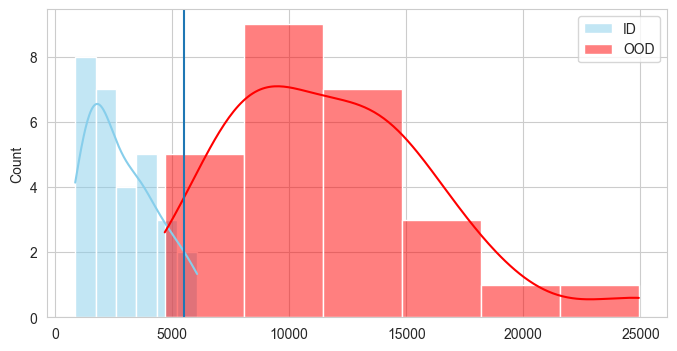

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(data=id_scores, color="skyblue", label='ID', stat="count", kde=True)
sns.histplot(data=ood_scores, color="red", label='OOD', stat="count", kde=True)
plt.axvline(5500) # 5200 is the eyeballed cutoff distance

plt.legend()
plt.show()

We can see that the model achieves descent separation and that a score between 5000 and 6000 looks to be a good cutoff value (for this ID)

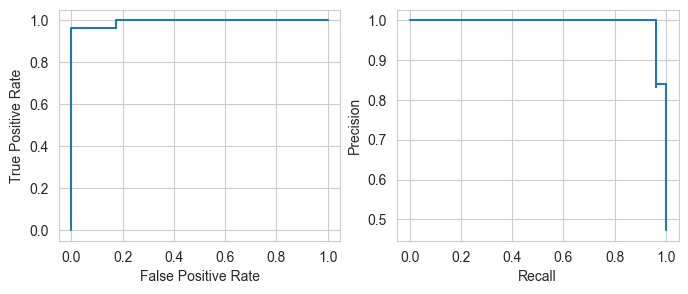

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

fpr, tpr, roc_thresholds = roc_curve(y_true, y_score)
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

## Automate cutoff distance selection

As we hope to be able to run a lot of models, we need to automate the choice of the cutoff distance. We use 2 classic methods to see if it matches the eye balled results

In [14]:
# convert to f score
f1_scores = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(f1_scores)
print(f"Best F1 cutoff={pr_thresholds[ix]:.2f}, F1-Score={f1_scores[ix]:.3f}")

Best F1 cutoff=6945.94, F1-Score=0.980


In [15]:
from sklearn.metrics import roc_auc_score, auc

auc = roc_auc_score(y_true, y_score)
print("Area under the ROC curve : %f" % auc)


def cutoff_youdens_j(fpr, tpr, thresholds):
    j_scores = tpr - fpr
    j_ordered = sorted(zip(j_scores, thresholds))
    return j_ordered[-1][1]


cutoff2 = cutoff_youdens_j(fpr, tpr, roc_thresholds)
print(f"Best ROC cutoff {cutoff2}")


Area under the ROC curve : 0.993369
Best ROC cutoff 6945.941933488371


### Check automated cutoff by looking at confusion matrix

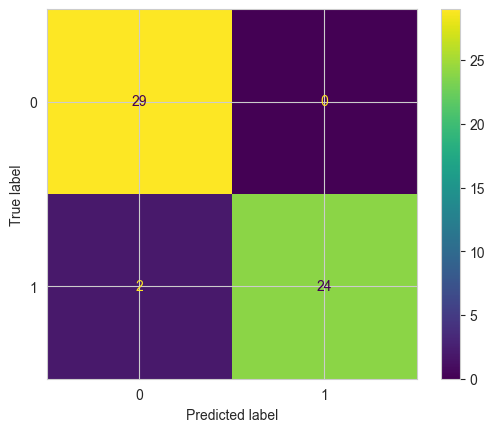

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_score > cutoff2)

cm_display = ConfusionMatrixDisplay(cm).plot()

## A performance metric for model comparison: taking into account speed requirements

It is possible to use bigger embedding space to get better semantics and results. But the Cisco **paper explicitly tells it wants inference speed  around 50ms. We should take this into account to tradeoff model selection**.
Also, given the sentences are "streaming in" we expect to re-evaluate overlapping piece of incomplete sentences which will generate a lot of inference calls.

In [17]:
def infer_all():
    np.array([detector.mahalanobis(s) for s in all_sentences])


import timeit

re_runs=10
total_time_sec = timeit.timeit(stmt='infer_all()', globals=globals(), number=re_runs)
avg_inference_time_ms = 1000 * total_time_sec / re_runs / len(all_sentences)
print(f"Execution time is {avg_inference_time_ms:.1} millis")

Execution time is 1e+01 millis


Let's add a simple penalty function: execution times above 50ms get max penalty score of 1. Our automatic model selection will be strongly be encouraged to choose model with fast inference speeds.
Our final model scoring function will be: `max(0, AUC - penalty)` which will vary from 1.0 (perfect score) to 0.0 (which can be reached with any model with inference time above 50ms)

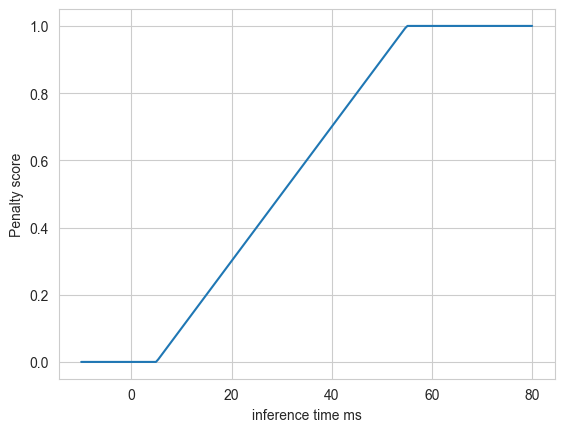

0.09966799462495582


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import math

x = np.linspace(-10, 80, 200)
delta = x - 5

# z = np.tanh(delta) * 0.5 + 0.5
exec_time_penalty_score = np.minimum(1, np.maximum(0, delta) / 50)


plt.plot(x, exec_time_penalty_score)
plt.xlabel("inference time ms")
plt.ylabel("Penalty score")


plt.show()

print(np.tanh(0.1))

## Manual error analysis

In [19]:
fp_mask = np.logical_and(y_score > cutoff2 ,y_true == 0)
for idx in np.where(fp_mask)[0]:
    print(f"'{all_sentences[idx]}' has been misclassified as OOD")


In [20]:
fn_mask = np.logical_and(y_score < cutoff2 ,y_true == 1)
for idx in np.where(fn_mask)[0]:
    print(f"'{all_sentences[idx]}' has been misclassified as ID")

'i can check the fly rates for you.' has been misclassified as ID


It is not very clear even for a human if this sentence is ID or OOD: it is related to car but nothing you expect to directly find in the FAQ

In [21]:
fp_mask = np.logical_and(y_score < cutoff2 ,y_true == 1)
for idx in np.where(fp_mask)[0]:
    print(f"'{all_sentences[idx]}' has been misclassified as ID")

'i can check the fly rates for you.' has been misclassified as ID


We can see this is a very general sentence... Maybe we should trim down the FAQ to the essential sentences before embedding it: this will avoid having small or basic sentences into it which can uselessly expand the shape of our ID cloud of points (embeddings)

## Finding a more user-friendly score

We follow the logic taken from this article: https://medium.com/balabit-unsupervised/calibrating-anomaly-scores-5e60b7e47553

We want our score function to:
- return scores in range 0 to 100
- prefers giving scores in the low range or in the high range but not in the middle. (What should you do with a score of 60?)

In [22]:
def make_calibrator(id_percentile=50, ood_percentile=50):
    r_id = np.percentile(id_scores, id_percentile)
    r_ood = np.percentile(ood_scores, ood_percentile)

    def _calibrate(scores):
        return np.clip(100*(scores - r_id) / (r_ood - r_id), 0, 100)

    return _calibrate

calibrate = make_calibrator()
calibrate(5000)

30.08066223828395

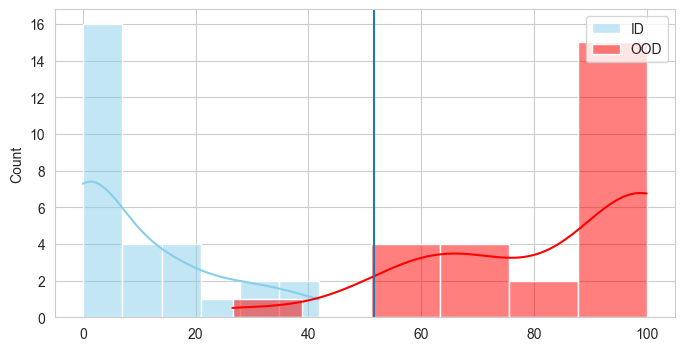

In [23]:
plt.figure(figsize=(8, 4))
sns.histplot(data=calibrate(id_scores), color="skyblue", label='ID', stat="count", kde=True)
sns.histplot(data=calibrate(ood_scores), color="red", label='OOD', stat="count", kde=True)
plt.axvline(calibrate(cutoff2)) # now cut off is at 50 is the eyeballed cutoff distance

plt.legend()
plt.show()

We can change top or bottom bounds to get more recall or more precision. Here is an example getting more precision:

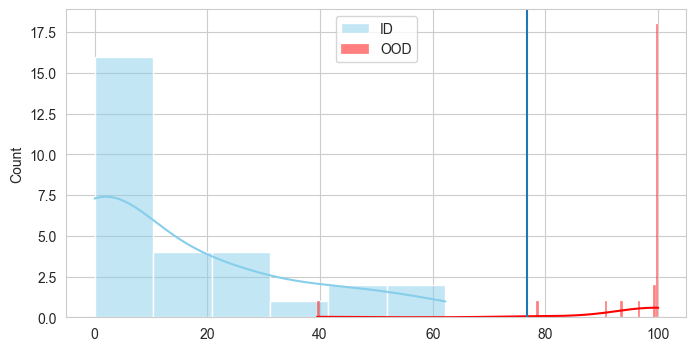

In [24]:
calibrate = make_calibrator(id_percentile=50, ood_percentile=30)
plt.figure(figsize=(8, 4))
sns.histplot(data=calibrate(id_scores), color="skyblue", label='ID', stat="count", kde=True)
sns.histplot(data=calibrate(ood_scores), color="red", label='OOD', stat="count", kde=True)
plt.axvline(calibrate(cutoff2)) # now cut off is at 50 is the eyeballed cutoff distance

plt.legend()
plt.show()

See how scores are much more separated now...